<a href="https://colab.research.google.com/github/PROFOUNDIVE/AIDHellCamp2/blob/dev1/baseline_code5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 6공학관 층 분류하기 - AID 지옥캠프2

- 작성된 환경: Window 11, Pip, Python 3.9, CUDA 11.8, VScode
- Google Colab 등의 클라우드 컴퓨팅 환경에서는 다른 동작을 할 가능성 있음

## 실행 전 사전 준비

### 모듈
- shell에서
``` shell
# Colab 환경은 필요한 모든 모듈이 설치되어 있어 설치할 필요 x
```
``` shell
# 본인 GPU(CUDA)에 맞는 버전을 설치해주세요
# 참고: https://pytorch.org/get-started/locally/
# ex1) Pip, CPU 환경
# pip3 install torch torchvision torchaudio
# ex2) Conda, CUDA 12.4 환경
# conda install pytorch torchvision torchaudio pytorch-cuda=12.4 -c pytorch -c nvidia
pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
```
```shell
pip3 install -U scikit-learn
pip3 install -U matplotlib
pip3 install tqdm
```

### 데이터 파일
- 데이터 파일을 root 경로(baseline_code.ipynb가 있는 폴더)에 압축해제 해주세요
- data link: https://www.kaggle.com/datasets/hyunseok21/jiokdata
- colab 환경이라면 다음 [챕터](#colab-환경에서-kaggle파일-다운로드하기---로컬환경이라면-건너뛰기) 확인해주세요
``` shell
📁root
 ├─📁test
 ├─📁train
 │  ├─📁2F_train
 │  ├─📁3F_train
 │  ├─📁4F_train
 │  └─📁5F_train
 └─📜baseline_code.ipynb
```

#### Colab 환경에서 kaggle파일 다운로드하기 - **로컬환경이라면 건너뛰기**

In [1]:
# 실행 시 업로드 버튼 활성화
# kaggle에서 발급받은 api key가 담긴 json 파일 업로드
COLAB = True
try:
  from google.colab import files
  files.upload()
except:
  COLAB = False

Saving kaggle.json to kaggle.json


In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
if COLAB:
  import kagglehub
  import shutil

  # Download latest version
  path = kagglehub.dataset_download("hyunseok21/jiokdata")

  print("Path to dataset files:", path)
  shutil.move(path+'/jiokdata/train', '/content/')
  shutil.move(path+'/jiokdata/test', '/content/')

100%|██████████| 5.72G/5.72G [04:18<00:00, 23.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/hyunseok21/jiokdata/versions/1


In [4]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=ac90438d03dacb8c87e1340cba377d8bb0bc26dfcd61c5cec21212c7c2fd53c2
  Stored in directory: /root/.cache/pip/wheels/8b/6f/9b/231a832f811ab6ebb1b32455b177ffc6b8b1cd8de19de70c09
Successfully built efficientnet_pytorch


# Train Data로 학습하기

## 모델 학습 (with train data)

### 모듈 불러오기

In [5]:
import time
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm

### CUDA 코어 테스트 & 할당

In [6]:
if torch.cuda.is_available():
  print(torch.cuda.get_device_name())
  print(torch.__version__)
  print(torch.version.cuda)
  x = torch.randn(1).cuda()
  print(x)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

Tesla T4
2.5.1+cu121
12.1
tensor([-0.3152], device='cuda:0')


device(type='cuda', index=0)

### 하이퍼 파라미터 (Hyper Parameter)

In [7]:
params = {
  # For Train
  'epoch': 2,
  'batch_size': 16,

  # CPU worker
  'workers': 4, # 본인 cpu 쓰레드의 절반 정도

  # imgShow
  'num_show_img': 5, # 데이터가 잘 로드 되었는지 확인 하는 셀에서 보여줄 데이터 개수, 학습과 관련 없음

  # For Optimizer
  'learning_rate': 0.001,
}

### 저장할 학습 완료 모델 파일 이름

In [8]:
pt_file_name = 'model.pt'

### 데이터 라벨링

In [9]:
class_names = {
  "0": "2F",
  "1": "3F",
  "2": "4F",
  "3": "5F",
}

### 데이터 전처리 & 데이터 로더 정의 & 사이즈 확인

In [10]:
import os
import random
import numpy as np
import torch

from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

# ------------------------------------------------------------------------
# 0) 난수 시드 고정 (전체적으로 동일한 결과 재현 가능)
# ------------------------------------------------------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
# torch.backends.cudnn.deterministic = True  # 필요시 활성화(학습 속도↓, 완전 재현성↑)

# ------------------------------------------------------------------------
# 1) 학습(train)용 증강 Transform & 검증/테스트용 Transform 정의
# ------------------------------------------------------------------------
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomChoice([
        transforms.Lambda(lambda x: x),  # (1) 아무것도 안 하기
        transforms.RandomResizedCrop((224, 224), scale=(0.8, 1.0)),  # (2) 랜덤 리사이즈 크롭
        transforms.RandomHorizontalFlip(p=1.0),                      # (3) 좌우 뒤집기
        transforms.RandomRotation(degrees=30),                       # (4) 회전
        transforms.ColorJitter(brightness=0.2, contrast=0.2,
                               saturation=0.2, hue=0.1)              # (5) 색상 변화
    ]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# valid/test에서는 증강을 적용하지 않고, 리사이즈 & 정규화만 수행
eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ------------------------------------------------------------------------
# 2) 전체 ImageFolder 불러오기 (transform은 일단 None)
#    - 전체 이미지 인덱스(list(range(len(full_dataset))))를 먼저 구분
# ------------------------------------------------------------------------
full_dataset = datasets.ImageFolder(
    root='./train',  # ImageFolder 구조의 이미지가 있는 폴더
    transform=None   # 나중에 Subset으로 각각 다른 transform을 줄 예정
)

all_indices = list(range(len(full_dataset)))
print("전체 이미지 개수:", len(full_dataset))

# ------------------------------------------------------------------------
# 3) 8:1:1 (train : valid : test) 분할
#    - 첫 분할: train 80%, 나머지(tmp) 20%
#    - 두 번째 분할: tmp 20% -> valid 10%, test 10%
# ------------------------------------------------------------------------
train_indices, tmp_indices = train_test_split(
    all_indices, test_size=0.2, random_state=SEED, shuffle=True
)
val_indices, test_indices = train_test_split(
    tmp_indices, test_size=0.5, random_state=SEED, shuffle=True
)

print(f"train 개수: {len(train_indices)} | valid 개수: {len(val_indices)} | test 개수: {len(test_indices)}")

# ------------------------------------------------------------------------
# 4) Subset을 통해 train, valid, test에 서로 다른 transform 적용
#    - train -> train_transform (증강 포함)
#    - valid, test -> eval_transform (증강 없음)
#
#    방법:
#      datasets.ImageFolder(...)를 다시 각각 만들되,
#      동일한 root 폴더를 사용하고 transform만 다르게 지정.
#      그리고 Subset에 (원본 ImageFolder, 인덱스) 적용.
# ------------------------------------------------------------------------
train_dataset = Subset(
    datasets.ImageFolder(root='./train', transform=train_transform),
    train_indices
)

val_dataset = Subset(
    datasets.ImageFolder(root='./train', transform=eval_transform),
    val_indices
)

test_dataset = Subset(
    datasets.ImageFolder(root='./train', transform=eval_transform),
    test_indices
)

# ------------------------------------------------------------------------
# 5) DataLoader 정의
# ------------------------------------------------------------------------
dataloaders = {
    'train': DataLoader(train_dataset,
                        batch_size=params['batch_size'],
                        shuffle=True,
                        num_workers=params['workers'],
                        pin_memory=True),
    'valid': DataLoader(val_dataset,
                        batch_size=params['batch_size'],
                        shuffle=False,
                        num_workers=params['workers'],
                        pin_memory=True),
    'test': DataLoader(test_dataset,
                       batch_size=params['batch_size'],
                       shuffle=False,
                       num_workers=params['workers'],
                       pin_memory=True)
}

# ------------------------------------------------------------------------
# 6) 배치 수 계산 및 출력
# ------------------------------------------------------------------------
batch_num = {
    'train': len(dataloaders['train']),
    'valid': len(dataloaders['valid']),
    'test': len(dataloaders['test'])
}

print('batch_size: %d | batch_num(train/valid/test): %d / %d / %d' %
      (params['batch_size'],
       batch_num['train'],
       batch_num['valid'],
       batch_num['test']))

전체 이미지 개수: 7208
train 개수: 5766 | valid 개수: 721 | test 개수: 721
batch_size: 16 | batch_num(train/valid/test): 361 / 46 / 46


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


### Train 함수
**입력 인자:**

model: 학습시킬 PyTorch 모델.  
criterion: 손실 함수 (예: nn.CrossEntropyLoss).
optimizer: 모델의 파라미터를 업데이트할 옵티마이저 (예: torch.optim.Adam).  
dataloaders: train과 valid 데이터를 로드하는 DataLoader 딕셔너리.  
num_epochs: 학습 에포크 수 (기본값: 25).

**출력값:**

model: 최종 학습 완료된 모델.  
best_idx: 가장 높은 검증 정확도를 기록한 에포크 번호.  
best_acc: 가장 높은 검증 정확도.  
train_loss, train_acc: 학습 손실 및 정확도의 기록.  
valid_loss, valid_acc: 검증 손실 및 정확도의 기록.

In [16]:
import torch
import copy
import time
from tqdm import tqdm

# Function to load the model and optimizer from a checkpoint file
def load_checkpoint(model, optimizer, checkpoint_path, device):
    checkpoint = torch.load(checkpoint_path)

    # Load model state dict
    model.load_state_dict(checkpoint['model_state_dict'])

    # Load optimizer state dict
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # Load best accuracy and epoch
    best_acc = checkpoint['best_acc']
    epoch = checkpoint['epoch']

    return model, optimizer, best_acc, epoch

def train_model(model, criterion, optimizer, dataloaders: dict, num_epochs=25, checkpoint_path=None):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss, train_acc, valid_loss, valid_acc = [], [], [], []

    # Load checkpoint if available
    start_epoch = 0
    if checkpoint_path:
        model, optimizer, best_acc, start_epoch = load_checkpoint(model, optimizer, checkpoint_path, device)
        print(f"Resuming training from epoch {start_epoch + 1} with best validation accuracy {best_acc:.1f}%")

    for epoch in range(start_epoch, num_epochs):  # Start from the last saved epoch
        print()
        print(f'Epoch {epoch + 1}/{num_epochs}:', '-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluation mode

            running_loss, running_corrects, num_cnt = 0.0, 0, 0

            count = 1
            pbar_dataloaders = tqdm(dataloaders[phase], desc=phase, ncols=70)
            for inputs, labels in pbar_dataloaders:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                num_cnt += len(labels)
                count += 1
            pbar_dataloaders.close()

            epoch_loss = running_loss / num_cnt
            epoch_acc = (running_corrects.double() / num_cnt).cpu() * 100

            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc)

            print(f'{phase} Loss: {epoch_loss:.2f} Acc: {epoch_acc:.1f}')

            if phase == 'valid' and epoch_acc > best_acc:
                best_idx = epoch + 1
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                print(f'==> best model saved - Epoch {epoch + 1} / {best_acc:.1f}%')

    # Final result
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best valid Acc: Epoch {start_epoch + 1} / {best_acc:.1f}%')

    model.load_state_dict(best_model_wts)

    # Save model checkpoint
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_acc': best_acc,
    }, pt_file_name)
    print('Checkpoint saved')

    return model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc

### 데이터 확인

In [12]:
def imgShow(input, title=None):
  """Img show for Tensor."""
  input = input.numpy().transpose((1,2,0))
  input = np.clip(input, 0, 1)
  plt.imshow(input)
  if title is not None:
    plt.title(title)
  plt.pause(0.001) # pause a bit so that plots are updated

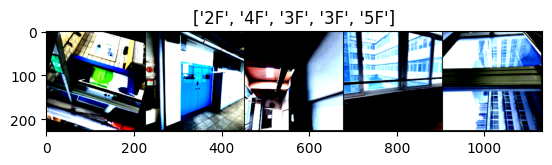

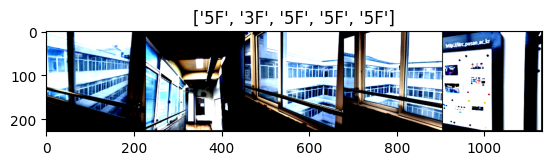

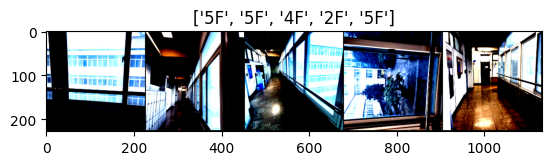

In [13]:
# train data
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs[:params['num_show_img']])
imgShow(out, title=[class_names[str(int(x))] for x in classes[:params['num_show_img']]])
# valid data
inputs, classes = next(iter(dataloaders['valid']))
out = torchvision.utils.make_grid(inputs[:params['num_show_img']])
imgShow(out, title=[class_names[str(int(x))] for x in classes[:params['num_show_img']]])
# test data
inputs, classes = next(iter(dataloaders['test']))
out = torchvision.utils.make_grid(inputs[:params['num_show_img']])
imgShow(out, title=[class_names[str(int(x))] for x in classes[:params['num_show_img']]])

### 모델을 장치로 할당

In [14]:
from torchvision.models import efficientnet_b0

# 1. EfficientNet 모델 초기화 (pre-trained weights 사용)
model = efficientnet_b0(pretrained=True)  # pretrained=True로 사전 학습된 가중치 로드

# 2. 최종 Fully Connected Layer 수정 (클래스 수에 맞게 변경)
num_classes = 4  # 예측할 클래스 수
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, num_classes)

# 3. 모델을 장치로 이동 (GPU 또는 CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

checkpoint_path = pt_file_name if os.path.exists(pt_file_name) else None

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 211MB/s]


### 손실함수 & 옵티마이저

Adam:
대부분의 경우 기본값으로 사용해도 잘 작동.  
SGD with Momentum:
데이터셋이 크거나, 안정적인 학습이 중요할 때 유리.  
AdamW:
EfficientNet 등 최신 아키텍처와 조합 시 추천.


In [15]:
# 손실함수
criterion = torch.nn.CrossEntropyLoss()

# # 옵티마이저
# optimizer = torch.optim.SGD(model.parameters(),
#                             lr=params['learning_rate'],
#                           )

# optimizer = torch.optim.SGD(model.parameters(),
#                             lr=0.01,
#                             momentum=0.9,
#                             weight_decay=1e-4)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-2)

### 학습 시작

In [17]:
model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc = train_model(
    model, criterion, optimizer, dataloaders, num_epochs=params['epoch'], checkpoint_path=checkpoint_path
)


Epoch 1/2: ----------


train: 100%|████████████████████████| 361/361 [09:54<00:00,  1.65s/it]


train Loss: 0.41 Acc: 86.0


valid: 100%|██████████████████████████| 46/46 [01:12<00:00,  1.58s/it]


valid Loss: 0.17 Acc: 94.3
==> best model saved - Epoch 1 / 94.3%

Epoch 2/2: ----------


train: 100%|████████████████████████| 361/361 [10:10<00:00,  1.69s/it]


train Loss: 0.21 Acc: 93.0


valid: 100%|██████████████████████████| 46/46 [01:14<00:00,  1.63s/it]


valid Loss: 0.13 Acc: 95.8
==> best model saved - Epoch 2 / 95.8%
Training complete in 22m 32s
Best valid Acc: Epoch 1 / 95.8%
Checkpoint saved


## 학습 결과 분석

best model info:
Model extracted from epoch 2
Valid Acc=96 / Valid Loss=0.1


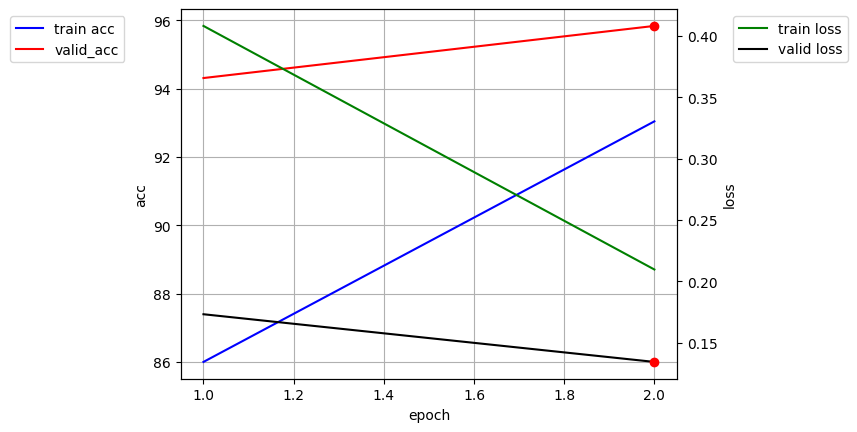

In [18]:
## 결과 그래프 그리기
print('best model info:\nModel extracted from epoch %d\nValid Acc=%1.f / Valid Loss=%.1f'%(best_idx, valid_acc[best_idx-1], valid_loss[best_idx-1]))
fig, ax1 = plt.subplots()

ax1.plot([n for n in range(1,len(train_acc)+1)], train_acc, 'b-', label='train acc')
ax1.plot([n for n in range(1,len(valid_acc)+1)], valid_acc, 'r-', label ='valid_acc')
plt.plot(best_idx, valid_acc[best_idx-1], 'ro')
ax1.set_xlabel('epoch')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('acc', color='k')
ax1.tick_params('y', colors='k')
plt.legend(bbox_to_anchor=(-0.1, 1.0), loc="upper right")
plt.grid()

ax2 = ax1.twinx()
ax2.plot([n for n in range(1,len(train_loss)+1)], train_loss, 'g-', label='train loss')
ax2.plot([n for n in range(1,len(valid_loss)+1)], valid_loss, 'k-', label='valid loss')
plt.plot(best_idx, valid_loss[best_idx-1], 'ro')
ax2.set_ylabel('loss', color='k')
ax2.tick_params('y', colors='k')
plt.legend(bbox_to_anchor=(1.1, 1.0), loc="upper left")


plt.show()

## 모델 TEST

In [19]:
def test_and_visualize_model(model, dataloaders, phase = 'test', num_images=4):
  # phase = 'train', 'valid', 'test'

  was_training = model.training
  model.eval()

  running_loss, running_corrects, num_cnt = 0.0, 0, 0

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders[phase]):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      loss = criterion(outputs, labels) # batch의 평균 loss 출력

      running_loss += loss.item() * inputs.size(0)
      running_corrects += torch.sum(preds == labels.data)
      num_cnt += inputs.size(0) # batch size

    test_loss = running_loss / num_cnt
    test_acc = running_corrects.double() / num_cnt
    print('test done : loss/acc : %.2f / %.1f' % (test_loss, test_acc*100))

  # 예시 그림 출력
  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders[phase]):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(1, num_images+1):
        ax = plt.subplot(num_images//2, 2, j)
        ax.axis('off')
        ax.set_title('%s : %s -> %s' %(
          'True' if class_names[str(labels[j].cpu().numpy())] == class_names[str(preds[j].cpu().numpy())] else 'False',
          class_names[str(labels[j].cpu().numpy())],
          class_names[str(preds[j].cpu().numpy())]
        ))
        imgShow(inputs.cpu().data[j])

      if i == 0: break

  model.train(mode=was_training) # 다시 train모드로 전환

test done : loss/acc : 0.10 / 97.4


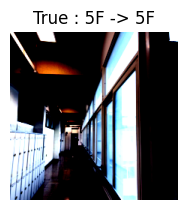

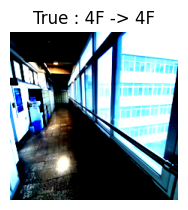

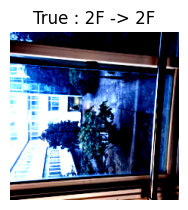

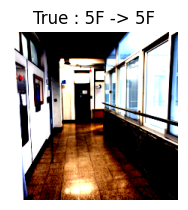

In [20]:
test_and_visualize_model(model, dataloaders, phase='test')

# Test 데이터 분류 및 CSV 만들기

In [21]:
import glob
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import sys

In [22]:
data_path = './test'
image_files = sorted(glob.glob(data_path + '/*'))
csv_filename = 'answer.csv'

os_name = sys.platform
path_split = '/'
if os_name.startswith('win'):
  path_split = '\\'

In [23]:
class TestImageDataset(Dataset):
  def __init__(self, files, transform):
    super().__init__()
    self.files = files
    self.transform = transform

  def __len__(self):
    return len(self.files)

  def __getitem__(self, index):
    file = self.files[index]
    try:
        img = Image.open(file).convert('RGB')
    except Exception as e:
        print(f"Error opening image {file}: {e}")
        raise
    img = self.transform(img)

    return img, file.split(path_split)[-1]

In [24]:
test_transform = transforms.Compose([
                        transforms.Resize((224, 224)), # 224x224 사이즈로 변환
                        transforms.ToTensor(), # 텐서화
                      ])

In [25]:
test_dataset = TestImageDataset(image_files, test_transform)

In [26]:
test_loader = DataLoader(test_dataset,
                         batch_size=params['batch_size'],
                         shuffle=False,
                         )

In [33]:
model_dict = torch.load(pt_file_name, map_location=device)

trained_model = efficientnet_b0(pretrained=True)  # pretrained=True로 사전 학습된 가중치 로드
trained_model.classifier[1] = torch.nn.Linear(trained_model.classifier[1].in_features, num_classes)
# checkpoint 딕셔너리에서 'model_state_dict'만 로드
trained_model.load_state_dict(model_dict['model_state_dict'])
trained_model = trained_model.to(device)

# CUDA 확인
print(f"CUDA:{next(trained_model.parameters()).is_cuda}")

<ipython-input-33-87ac44e0c6a0>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict = torch.load(pt_file_name, map_location=device)


CUDA:True


In [34]:
def test_and_make_csv(model, dataloader):
  # phase = 'train', 'valid', 'test'

  model.eval()

  answer_csv = 'id,floor\n'

  pbar_dataloaders = tqdm(dataloader,
                          desc='Making Csv',
                          ncols=70)
  with torch.no_grad():
    for inputs, filenames in pbar_dataloaders:
      inputs = inputs.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(len(preds)):
        answer_csv += f'{filenames[j].split(".")[0]},{class_names[str(preds[j].cpu().numpy())]}\n'
  pbar_dataloaders.close()

  with open(csv_filename, 'w') as file:
    file.write(answer_csv)
    print(f'{csv_filename}가 생성되었습니다.')

In [35]:
test_and_make_csv(trained_model, test_loader)

Making Csv: 100%|█████████████████████| 50/50 [01:30<00:00,  1.82s/it]

answer.csv가 생성되었습니다.


In [37]:
# 이미 2epoch 학습한 상태에서 저장된 model.pt가 있다고 가정
checkpoint_path = 'model.pt'  # 저장된 체크포인트 경로

model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc = train_model(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    dataloaders=dataloaders,
    num_epochs=4,              # 총 몇 epoch까지 학습할지 설정(예: 10)
    checkpoint_path=checkpoint_path
)


<ipython-input-16-15cec8e63762>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Resuming training from epoch 3 with best validation accuracy 95.8%

Epoch 3/4: ----------


train: 100%|████████████████████████| 361/361 [09:45<00:00,  1.62s/it]


train Loss: 0.14 Acc: 95.1


valid: 100%|██████████████████████████| 46/46 [01:10<00:00,  1.53s/it]


valid Loss: 0.07 Acc: 98.5
==> best model saved - Epoch 3 / 98.5%

Epoch 4/4: ----------


train: 100%|████████████████████████| 361/361 [09:30<00:00,  1.58s/it]


train Loss: 0.11 Acc: 96.4


valid: 100%|██████████████████████████| 46/46 [01:09<00:00,  1.52s/it]


valid Loss: 0.03 Acc: 99.0
==> best model saved - Epoch 4 / 99.0%
Training complete in 21m 37s
Best valid Acc: Epoch 3 / 99.0%
Checkpoint saved


In [39]:
test_and_make_csv(trained_model, test_loader)

Making Csv: 100%|█████████████████████| 50/50 [01:28<00:00,  1.78s/it]

answer.csv가 생성되었습니다.


In [ ]:
# 이미 2epoch 학습한 상태에서 저장된 model.pt가 있다고 가정
checkpoint_path = 'model.pt'  # 저장된 체크포인트 경로

model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc = train_model(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    dataloaders=dataloaders,
    num_epochs=4,              # 총 몇 epoch까지 학습할지 설정(예: 10)
    checkpoint_path=checkpoint_path
)
